<h1 align="center"> Segmenting and Clustering Neighborhoods in Toronto </h1>

## Introduction

In this notebook, we will explore, segment and cluster neighborhoods in Toronto according to their main venues, such as parks, museums or restaurants.

<br>

<i><u>Notes :</u></i>
 * <i>This assignment is part of the Coursera's course : Applied Data Science Capstone, module 3</i>
 * <i>__For peers reviewing readers :__ As stated in the assignment, only one notebook will be submitted, but each part is clearly defined by markdown cells.</i>

---

<h2>Table of contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Retrieving the neighborhoods in Toronto</a></li>
        <li><a href="#ref2">Localizing the neighborhoods</a></li>
        <li><a href="#ref3">Exploration and clustering</a></li>
    </ol>
</div>


In order to smoothly work with our data, let's import and install all the dependencies we will need :

In [96]:
import numpy as np
import pandas as pd

# Package to scrape a website
import requests
!pip install beautifulsoup4
!pip install lxml
from bs4 import BeautifulSoup

# Package to convert an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim 

# Package to render map
import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

<a id="ref1"></a>
## 1. Retrieving the neighborhoods in Toronto

The purpose of this project is to explore the neighborhoods of Toronto. If like me you know this city just by its name (and only with a broad idea of its location on a map...), then the first step is to find global information, specially on how this city is subdivided.

A quick look on Wikipedia provides us this useful link with the postal codes of Toronto's districts:  
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

The next step consists in retrieving these information into a dataframe to work on it later.





### Scraping a website

Using the Wikipedia's page, we can see that the list of postal codes is written as a table, but not directly accessible as a JSON or CSV file.  
However, thanks to Python libraries, retrieving these data is really simple and requires only few lines of code.  
In this example, we will use the **BeautifulSoup** library as following :

In [2]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content)
table = soup.find_all('table')[0] 
df_wiki = pd.read_html(str(table))[0]
df_wiki.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Now we have a dataframe filled with all the neighborhoods in Toronto, however some data looks not coherent and some are even irrelevant...   
Brace yourself, data wrangling is coming!


### Data wrangling

After a first glimpse, we can see some of the boroughs (and neighborhoods) are not assigned.  
These data are useless in our project, thus we will drop the associated row.

In [3]:
#To avoid any mistake, we create a new dataframe
df_neigh = pd.DataFrame(df_wiki)
df_neigh.rename(columns={'Postcode':'PostalCode'}, inplace=True)

#We delete the row for which the 'Borough' is 'Not assigned'
print("df_neigh.shape before dropping data :", df_neigh.shape)
df_neigh.replace("Not assigned", np.nan, inplace=True)
df_neigh.dropna(subset=["Borough"], axis=0, inplace=True)
df_neigh.reset_index(drop=True, inplace=True)

print("df_neigh.shape after dropping data :", df_neigh.shape)
df_neigh.head()

df_neigh.shape before dropping data : (287, 3)
df_neigh.shape after dropping data : (210, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


However, some cases appear with only the _Neighborhood_ column _Not assigned_, as illustrated by the following row :

In [4]:
df_neigh.iloc[6]

PostalCode               M9A
Borough         Queen's Park
Neighborhood             NaN
Name: 6, dtype: object

In this case, we decide to assign the name of the _Borough_ to the _Neighborhood_ .  
  For this aim, we use the following loop :

In [5]:
for i in range(df_neigh.index.max()+1):
    if pd.isna(df_neigh.iloc[i,2]):
        df_neigh.iloc[i,2] = df_neigh.iloc[i,1]

Thanks to this modification, we obtain the following results on the same example :

In [6]:
df_neigh.iloc[6]

PostalCode               M9A
Borough         Queen's Park
Neighborhood    Queen's Park
Name: 6, dtype: object

Finally, we can see that the `PostalCode` column contains several time the same entries, like _M6A_, which will not be convenient when geolocalizing our data in the next paragraph.  
Our idea is to merge the value of several rows with a different _Neighborhood_ but with the same _PostalCode_ into only one row.

In [8]:
#In order to drop the unused row, we scan the dataframe from the last row
for i in range(df_neigh.index.max(), 0,-1):
    #We compare the PostalCode of the current row with the one above,
    #if equal, we concatenate the neighborhood cell and drop the row
    if df_neigh.iloc[i-1,0] == df_neigh.iloc[i,0]:
        df_neigh.iloc[i-1,2] = df_neigh.iloc[i-1,2] + ', ' + df_neigh.iloc[i,2]
        df_neigh.drop([i], inplace=True)

#Once out of the loop, we reset the index
df_neigh.reset_index(drop=True, inplace=True)

df_neigh.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


At this point we have a dataframe of all the neighborhoods in Toronto, sorted by their PostalCode.  
Before going to the next phase, a small glimpse on our work in this paragraph :

In [9]:
print("Shape of the initial dataframe from scraping the Wikipedia website :", df_wiki.shape)
print("Shape of the new dataframe, ready for the next phase : ", df_neigh.shape)
df_neigh

Shape of the initial dataframe from scraping the Wikipedia website : (287, 3)
Shape of the new dataframe, ready for the next phase :  (103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern
101,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So..."


<a id="ref2"></a>
## 2. Localizing the neighborhoods

In the previous paragraph, we retrieved the neighborhoods of Toronto, but without any information about their localization.  
In this part, we tried to use the __Geocoder Python__ package to assign a longitude and a latitude to each postal code of our dataframe, however all the coordinates were the same, namely the ones of Toronto.  
Therefore, we use the provided data by Coursera, available under the following link as a csv file:  
http://cocl.us/Geospatial_data

In [10]:
#We define a new dataframe to work on in order to avoid any issue in case of mistake
df_gps = pd.DataFrame(df_neigh)

#We extract the data provided by Coursera :
df_coord = pd.read_csv('http://cocl.us/Geospatial_data')
df_coord.rename(columns={'Postal Code':'PostalCode'}, inplace=True)

Even if the following algorithm failed, I prefer to share it with the reader who could propose a solution in case an error is hidden or if another package could make the job.

In [ ]:
# In this cell, we can see the algorithm used to try to retrieve automatically the coordinates of
#each postal code.
# Unfortunately, when the OS doesn't crash and despite the loop to avoid a 'None' value, the
#coordinates are always the same : latitude 43.653963 and longitude -79.387207.
# These values correspond to Toronto coordinates.

location = None
for postcode in df_gps['PostalCode']:
    address = postcode + ', Toronto, Ontario'
    while location == None:
        geolocator = Nominatim(user_agent="toronto_explorer")
        location = geolocator.geocode(address)
    
    latitude = location.latitude
    longitude = location.longitude
    print("Coordinate of ", postcode, ' : ', latitude, longitude)

Using the csv file stored in the _df_coord_ dataframe, we can merge it with the _df_neigh_ dataframe obtained at the end of the first part in order to associate coordinates to each postal code. 

In [11]:
df_gps = pd.DataFrame(df_neigh.merge(df_coord, on='PostalCode', how='inner'))
print("Shape of the dataframe after adding the two new columns :", df_gps.shape)
df_gps.head()

Shape of the dataframe after adding the two new columns : (103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


With this last dataframe, we have all the information required to plot a map and begin the exploration of Toronto.  
By the way, what could be better to end this part than displaying the map of Toronto ? To do so, we are using the __Folium__ library, placing a mark for each postal code.

In [12]:
# Retrieving the coordinates of Toronto to prepare the Folium map
address ='Toronto, Ontario'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map
for lat, lng, borough, postalcode in zip(df_gps['Latitude'], df_gps['Longitude'], df_gps['Borough'], df_gps['PostalCode']):
    label = '{}, {}'.format(postalcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

So far, we begin to be familiar with Toronto, so let's move on to explore its venues !

<a id="ref1"></a>
## 3. Exploration and clustering

To recall, the purpose of this project is to cluster the neighborhoods in Toronto depending on their main venues.  
In order to find these venues, we will use the __Foursquare API__, which allows us to explore a place based on its location.


#### Restricting the dataset

As this project is just an exercise to apply data science methodology, we will focus on Toronto's downtown.  
Firstly we restrict our dataframe to borough which name contains _'Toronto'_ .  
Then we add these marks on the Folium map (in red color) to see how this restriction affects our dataset.


In [13]:
toronto_data = df_gps[df_gps['Borough'].str.contains('Toronto', regex=False)].reset_index(drop=True)

In [14]:
for lat, lng, borough, postalcode in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['PostalCode']):
    label = '{}, {}'.format(postalcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc3139',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

    
map_toronto

#### Preparing the Foursquare API

As now we have the location to explore, it is time to prepare the Foursquare API.  
After creating a developer account on their website (link <a href='https://fr.foursquare.com/developers'> here</a>), we can use our credentials to query data.

In [15]:
# Credential for Foursquare API
CLIENT_ID = '4MT2XSW05ARLQV0UGJ4TB2KLPWLYM24GKVUNZLG2PRDIEGEH'
CLIENT_SECRET = '03CGWIZFP12ZHXEZOXEHPHE05N0DSGBRNKFA25V1JOSLHFIQ'
VERSION = '20180605' # Foursquare API version

We then set two more parameters :
 * `LIMIT` : maximal number of venues retrieved when querying _Foursquare API_;
 * `radius-borough` : Radius to search within, in meters.  
 
To determine the last parameter, we first decide to choose a walking distance so less than a kilometer but we also try different path and display them on a folium map to check if we are covering enough distance or if we are fully overlapping our boroughs.

In [16]:
# Restart a new map to delete the old and irrelevant marks
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, postalcode in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['PostalCode']):
    label = '{}, {}'.format(postalcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5, #this radius is NOT in meters and autoscale
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc3139',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    folium.Circle(
        [lat, lng],
        radius=700,  # this radius is in meters
        color='red').add_to(map_toronto)
   
map_toronto

On this map, we only displayed the chosen value of `radius_borough = 700` as it covers part of the map but avoid each borough to collapse into another.  
However we can see a bunch of boroughs highly overlapping in the downtown. This should not be an issue as we want to cluster Toronto, therefore these different boroughs will certainly fit in a same group.  
In fact, the empty spaces while going out of the downtown could be a real issues as we could miss important data. A solution would be to subdivided our current borough and determine their venues in the chosen radius. Actually these voids are explained by our choice to group several neighborhoods into a unique borough based on their postal code.  
But, for the same reason when we decided to focus on a few boroughs instead of all Toronto, we will not investigate further as our project is just an overview to apply a Data Science methodology.

In [17]:
LIMIT = 50
radius_borough = 700

Before starting the venues exploration, we also define a new function to clean information retrieved by the API queries because the results will be a JSON file and would not be easy to read directly.

In [18]:
# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Finally, to retrieve the main venues for each location in the defined perimeter, we define a function which take our dataframe as an input and produce another dataframe in output.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius_borough):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # Uncomment if need to follow the process
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Retrieving the venues

Using the last function, we can easily access the desired data :

In [20]:
toronto_venues = getNearbyVenues(names=toronto_data['PostalCode'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

To check the results, a quick view provide the following information :

In [21]:
toronto_venues.head()

,Postal Code,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,M5A,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


To explore these data, the method `groupby` followed by `count` provide us an interesting view :

In [22]:
toronto_venues.groupby('Postal Code').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal Code,,,,,,
M4E,43,43,43,43,43,43
M4K,50,50,50,50,50,50
M4L,46,46,46,46,46,46
M4M,50,50,50,50,50,50
M4N,4,4,4,4,4,4
M4P,21,21,21,21,21,21
M4R,40,40,40,40,40,40
M4S,50,50,50,50,50,50
M4T,7,7,7,7,7,7


In fact, even if we set a limit of just 50 for the number of retrieved venues, not all boroughs achieved this limit and in this case they are mainly in the downtown, all overlapping each others.  
On the contrary, some boroughs just owns few venues.
  
Another point is to check how many venues we have in total and in how many categories they fit.

In [23]:
print('There are {} venues.'.format(len(toronto_venues['Venue'])))
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 1596 venues.
There are 242 uniques categories.


#### One-Hot Encoding

To prepare the clustering algorithm, we use the one-hot encoding process to obtain a new dataframe based only on two values : 0 (does not have the venue) or 1 (has the venue).

In [98]:
# using the get_dummies pandas method
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postal Code,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Overview the data

With the one-hot encoding dataframe, we can compute the frequency of occurence for each category :

In [99]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped.head()

,Postal Code,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.023256,0.0,0.0,0.023256,0.00,0.00,0.0,0.0,0.000000,0.00
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.020000,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.000000,0.02
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.021739,0.00
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.02,0.02,0.0,0.0,0.000000,0.02
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.000000,0.00


Based on these frequencies, we can generate a rank of occurrence for each borough. Let's check the five first categories for each of them :

In [100]:
num_top_venues = 5

for postcode in toronto_grouped['Postal Code']:
    print("----"+postcode+"----")
    temp = toronto_grouped[toronto_grouped['Postal Code'] == postcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M4E----
            venue  freq
0             Pub  0.07
1             Bar  0.07
2          Bakery  0.05
3       Gastropub  0.05
4  Sandwich Place  0.05


----M4K----
                venue  freq
0    Greek Restaurant  0.20
1         Coffee Shop  0.06
2      Ice Cream Shop  0.04
3  Italian Restaurant  0.04
4                Café  0.04


----M4L----
               venue  freq
0  Indian Restaurant  0.09
1     Sandwich Place  0.07
2      Grocery Store  0.04
3                Gym  0.04
4               Café  0.04


----M4M----
                 venue  freq
0                 Café  0.10
1          Coffee Shop  0.08
2   Italian Restaurant  0.06
3               Bakery  0.06
4  American Restaurant  0.04


----M4N----
              venue  freq
0       Swim School  0.25
1              Park  0.25
2          Bus Line  0.25
3  Business Service  0.25
4           Airport  0.00


----M4P----
              venue  freq
0              Park  0.10
1       Pizza Place  0.10
2  Greek Restaurant  0.05
3    Sandw

Finally for the exploration part, it would be interesting to generate a dataframe containing the most common venues instead of just printing them like in the previous cell.

Let's first write a function to sort the venues in descending order.

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now we can create the dataframe and display the top 10 venues for each postal code.

In [101]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postcode_venues_sorted = pd.DataFrame(columns=columns)
postcode_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

postcode_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Bar,Pub,Bakery,Breakfast Spot,Gastropub,Coffee Shop,Café,Sandwich Place,Home Service,Ice Cream Shop
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Café,Bakery,Restaurant,Pub,Bookstore,Ice Cream Shop,Juice Bar
2,M4L,Indian Restaurant,Sandwich Place,Café,Grocery Store,Gym,Park,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,Farmers Market
3,M4M,Café,Coffee Shop,Italian Restaurant,Bakery,Bar,American Restaurant,Rock Club,Neighborhood,Boutique,Electronics Store
4,M4N,Park,Swim School,Bus Line,Business Service,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster the boroughs 

We are now ready to launch the k-means algorithm process.  
But first of all we need to determine how many clusters provide the best accuracy in our project. To determine this number, we use the Elbow Criterion :

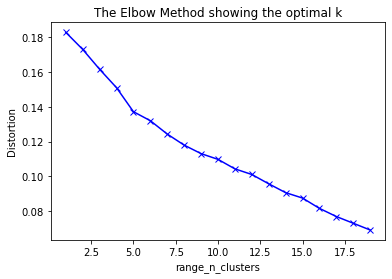

In [92]:
toronto_grouped_clustering = toronto_grouped.drop('Postal Code', 1)

# k means determine k
distortions = []
range_n_clusters = range(2,21)
for k in range_n_clusters:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('range_n_clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As illustrated on the above figure, the Elbow Criterion can not be used in this context as we are not able to read any change in the graph.  
To overpass this problem, another method can be used to find the optimal number of cluster, the Silhouette Method :

For n_clusters = 2, silhouette score is 0.48963194140688143)
For n_clusters = 3, silhouette score is 0.48808124247540874)
For n_clusters = 4, silhouette score is 0.4258848923148983)
For n_clusters = 5, silhouette score is 0.4127653030329357)
For n_clusters = 6, silhouette score is 0.036832046710028696)
For n_clusters = 7, silhouette score is 0.06330522535354752)
For n_clusters = 8, silhouette score is 0.049549614699346795)
For n_clusters = 9, silhouette score is 0.040612499698768546)
For n_clusters = 10, silhouette score is 0.04491989685460641)
For n_clusters = 11, silhouette score is 0.04368991291245318)
For n_clusters = 12, silhouette score is 0.03546003651474656)
For n_clusters = 13, silhouette score is 0.04640155603847743)
For n_clusters = 14, silhouette score is 0.05677304869234442)
For n_clusters = 15, silhouette score is 0.059229542882777104)
For n_clusters = 16, silhouette score is 0.04908256812931538)
For n_clusters = 17, silhouette score is 0.0653918519754937)
For n_clusters 

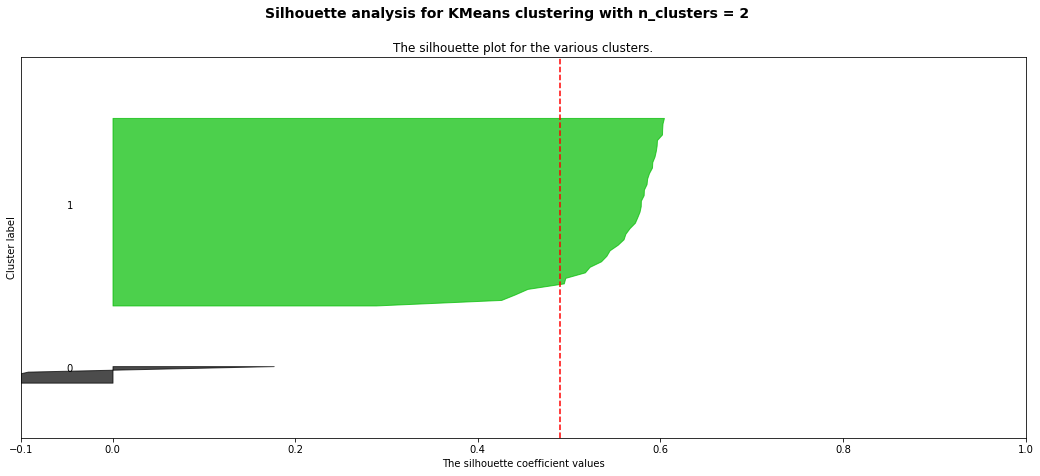

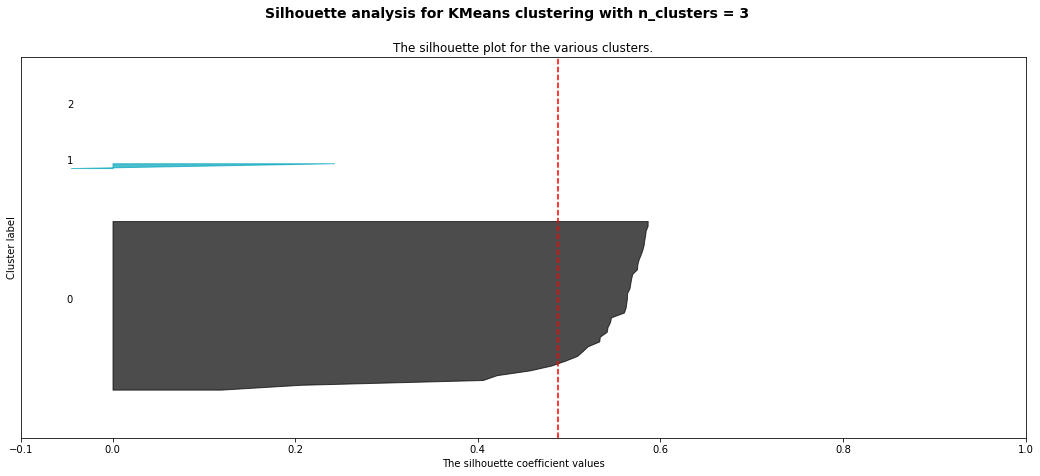

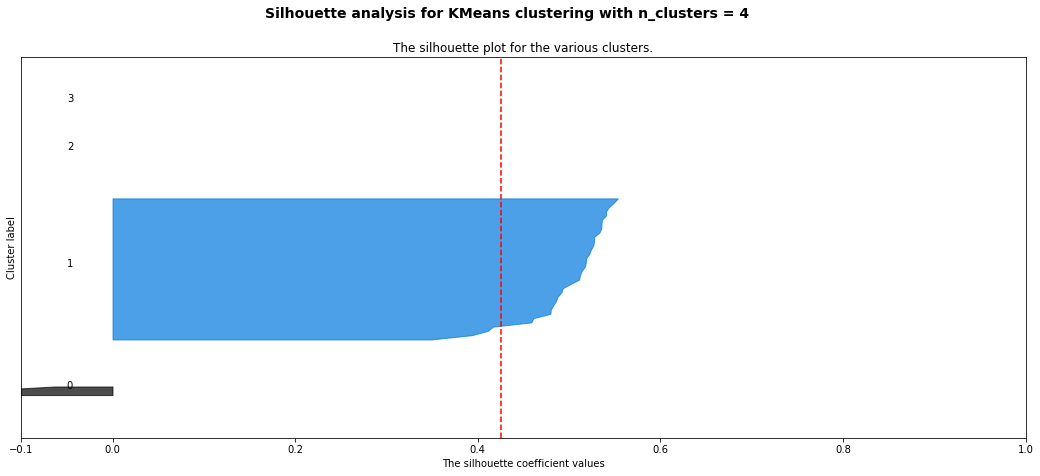

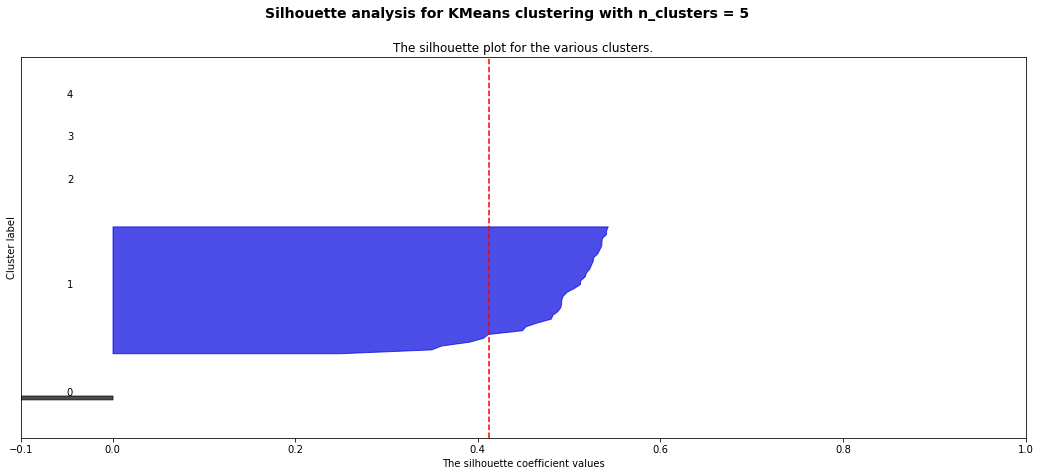

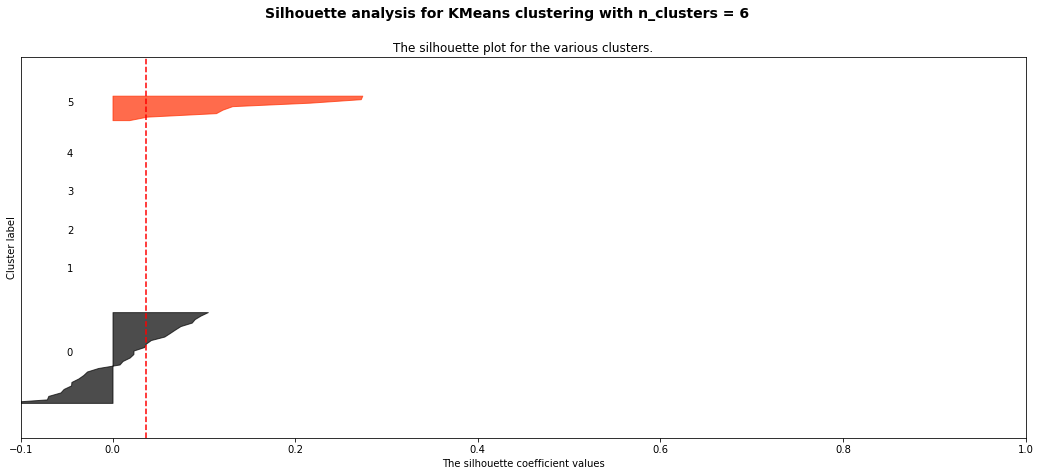

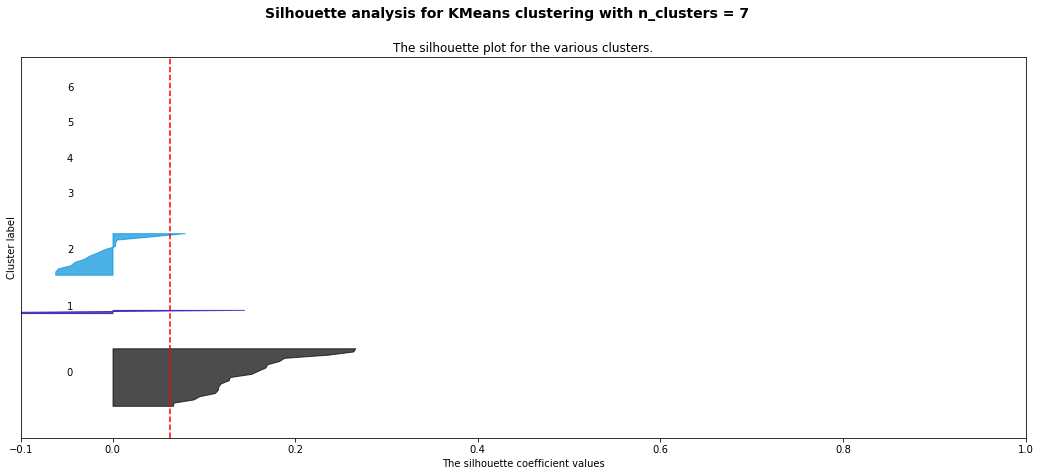

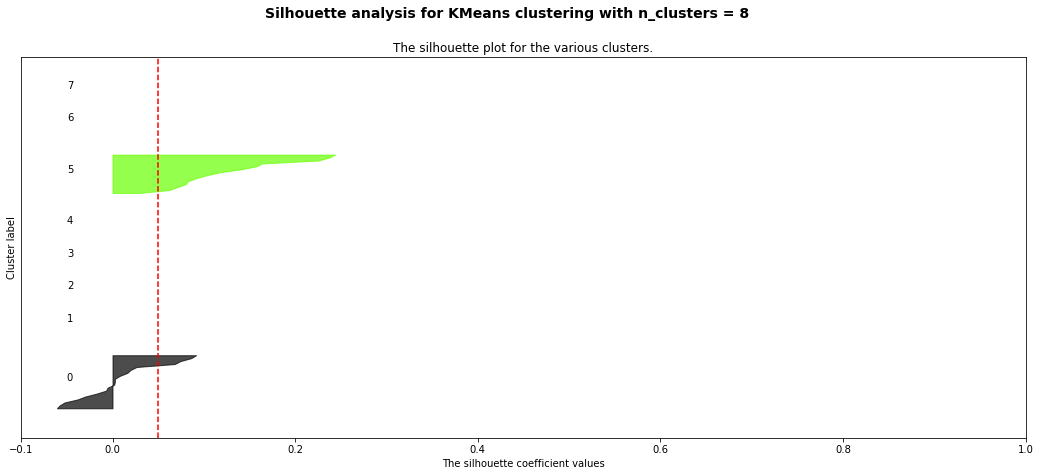

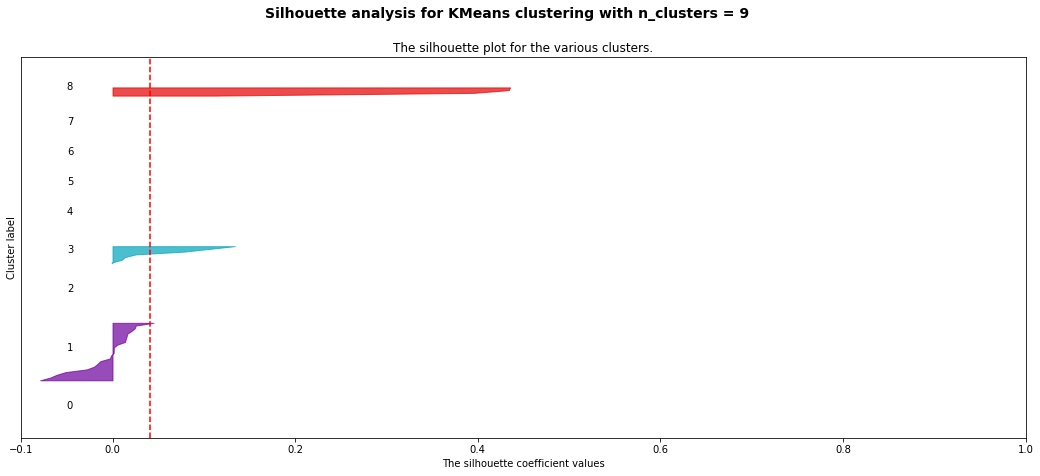

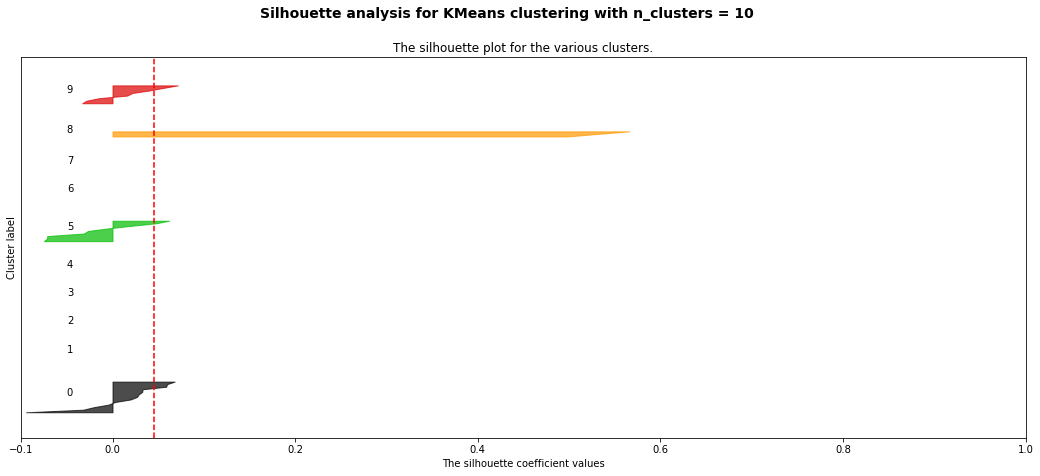

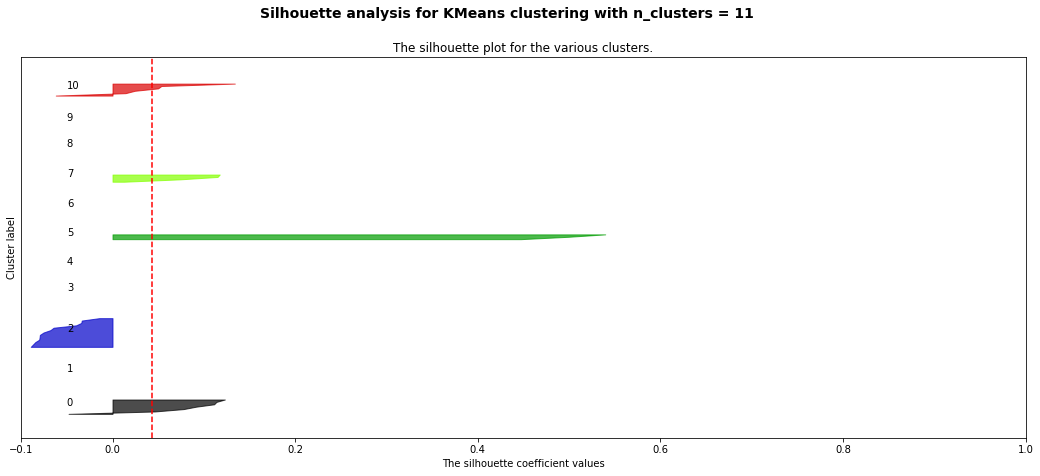

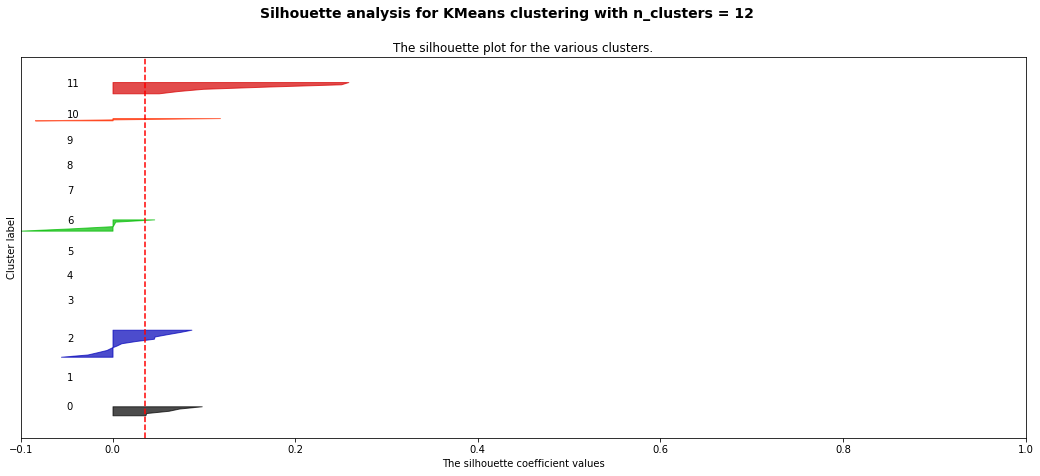

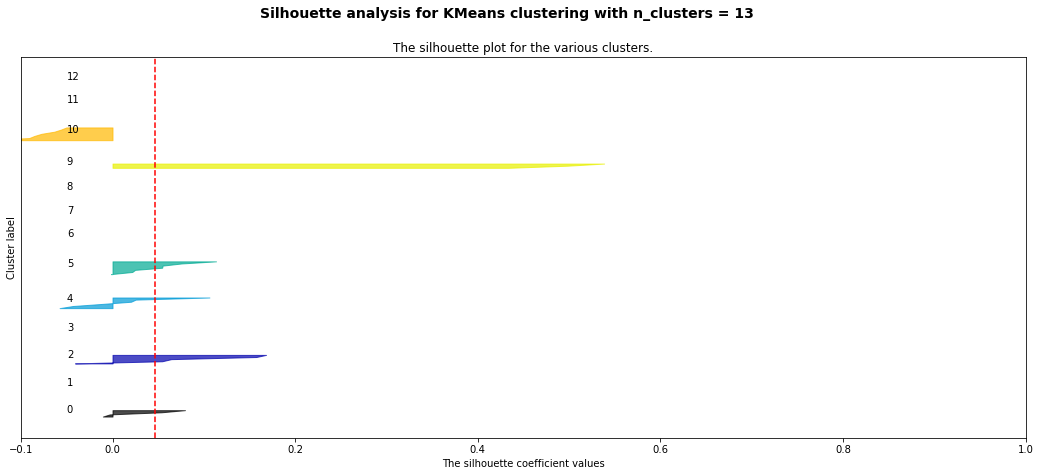

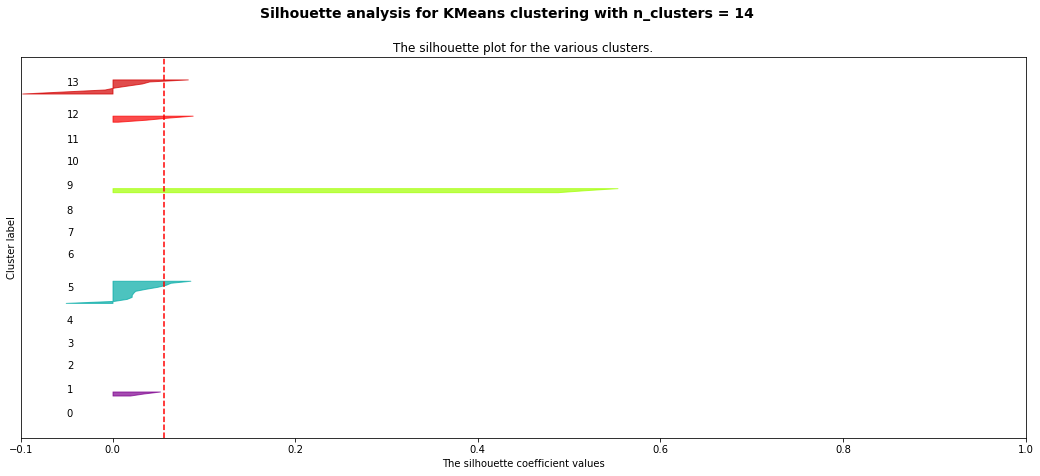

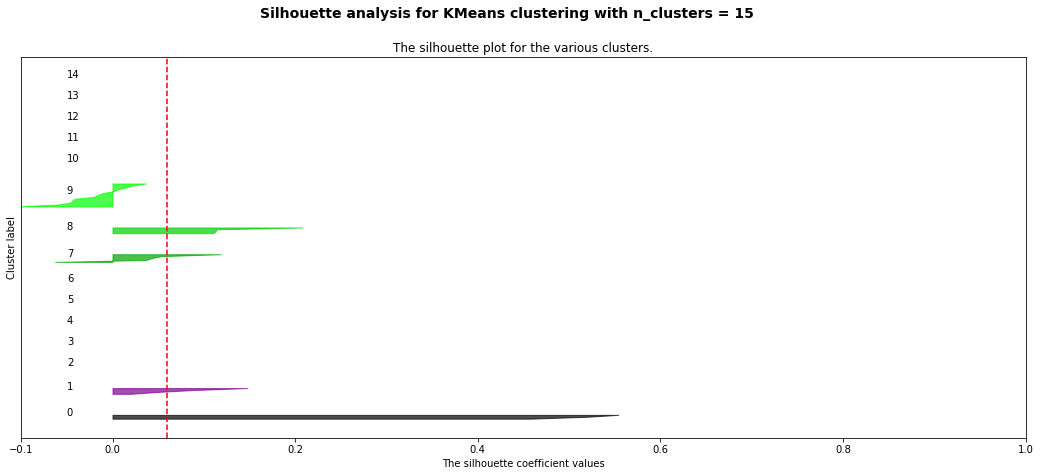

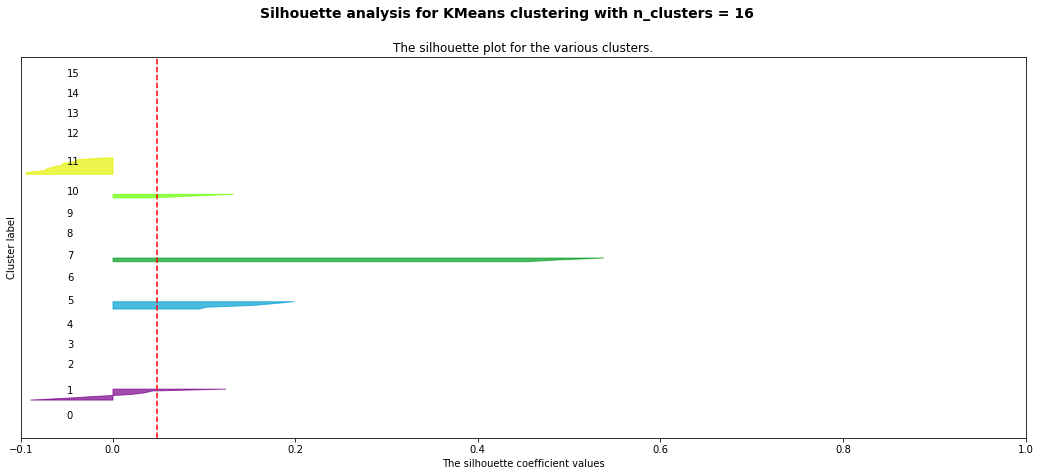

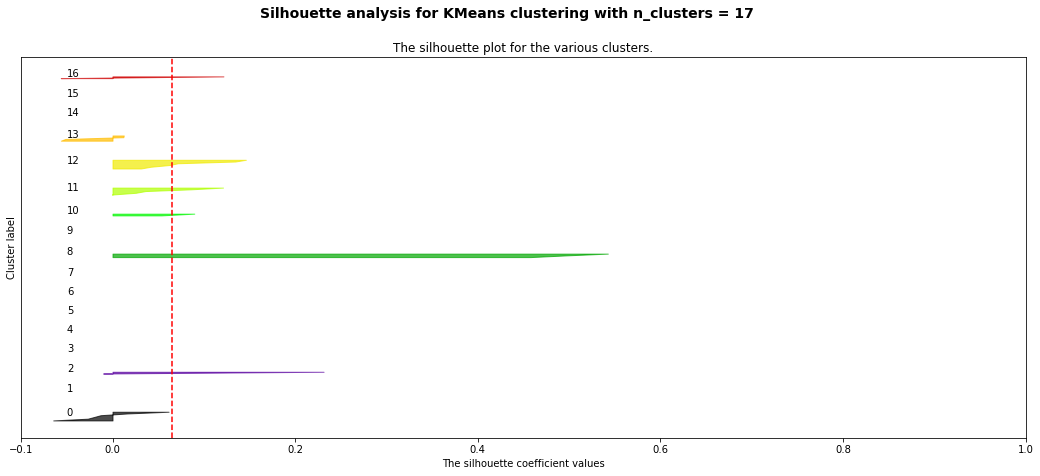

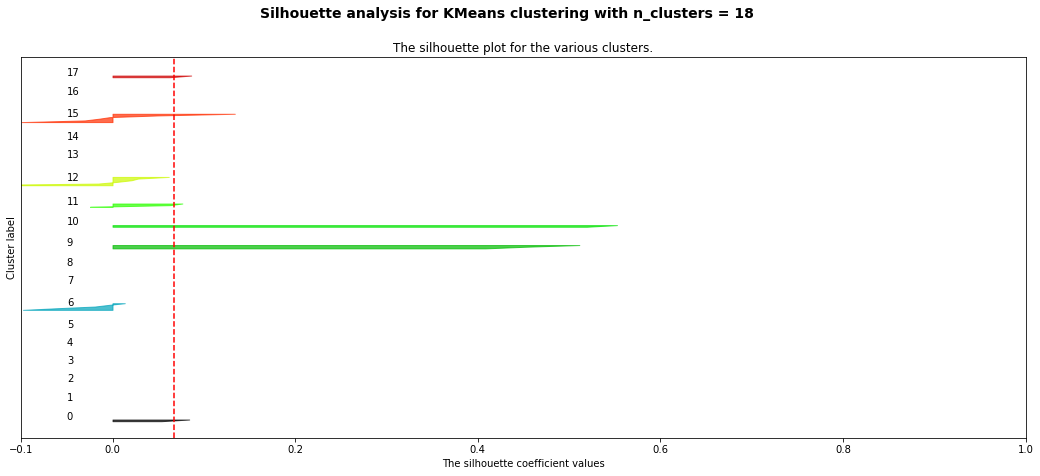

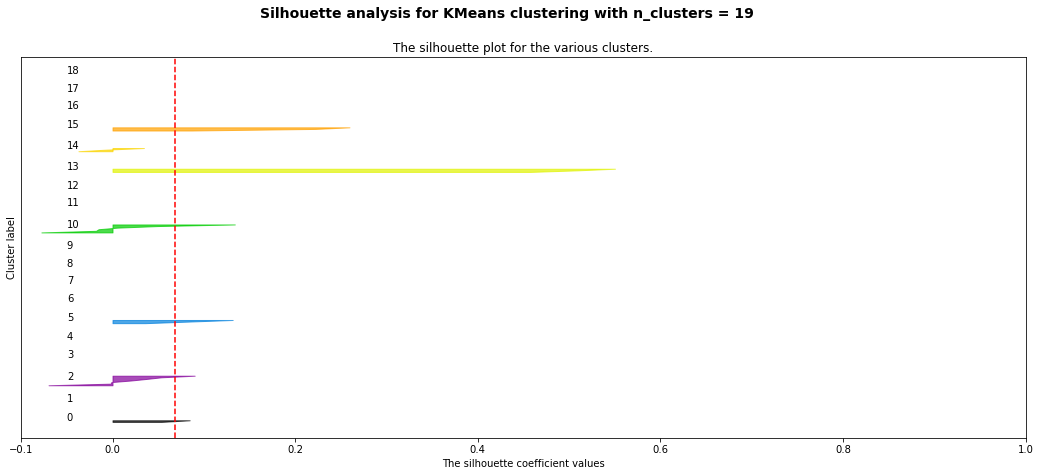

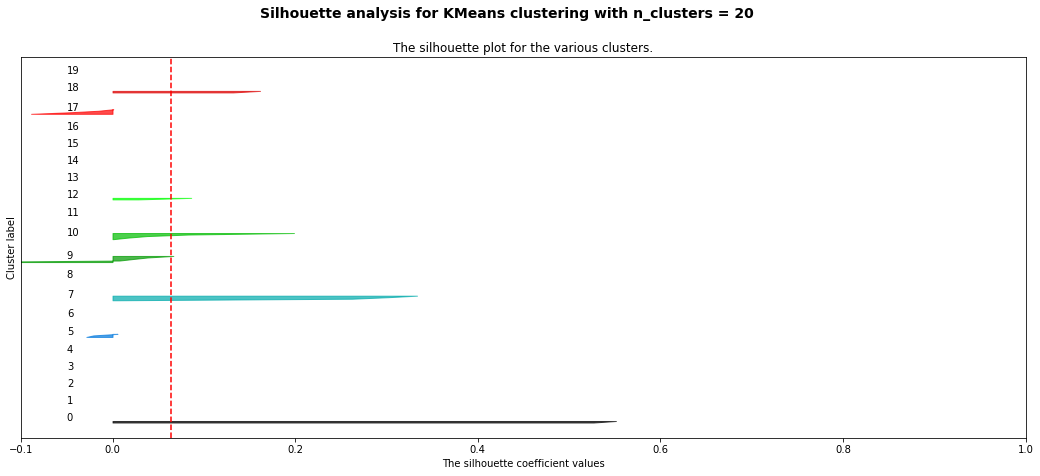

In [82]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(toronto_grouped_clustering) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters).fit(toronto_grouped_clustering)
    cluster_labels = clusterer.fit_predict(toronto_grouped_clustering)

    silhouette_avg = silhouette_score(toronto_grouped_clustering, cluster_labels)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, silhouette_avg))
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(toronto_grouped_clustering, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    plt.suptitle(("Silhouette analysis for KMeans clustering "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

With these figures we can see that we always have a strong group with most of the data, and the silhouette score of the other are clustering around 0, meaning overlapping cluster, or even going negative, corresponding to a wrong attribution.  
However these results could be explained as we restricted our perimeter to a specific localization but still grouping several neighborhood together.  
Based on that, we decide to cluster our boroughs into only 3 groups, in order to limit the number of unique item in a group.

In [102]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] 

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [103]:
# add clustering labels
postcode_venues_kmean = pd.DataFrame(postcode_venues_sorted)
postcode_venues_kmean.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(postcode_venues_kmean.set_index('Postal Code'), on='PostalCode')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,0,Coffee Shop,Café,Pub,Park,Bakery,Breakfast Spot,Performing Arts Venue,Theater,Mexican Restaurant,Dessert Shop
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,0,Coffee Shop,Italian Restaurant,Burger Joint,Gastropub,Sushi Restaurant,Park,Yoga Studio,Creperie,Burrito Place,Sandwich Place
2,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Cosmetics Shop,Bookstore,Italian Restaurant,Theater,Middle Eastern Restaurant,Ramen Restaurant,Miscellaneous Shop,Burrito Place
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Restaurant,Coffee Shop,Park,Farmers Market,Italian Restaurant,Beer Bar,Bakery,BBQ Joint,Hotel
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Bar,Pub,Bakery,Breakfast Spot,Gastropub,Coffee Shop,Café,Sandwich Place,Home Service,Ice Cream Shop


In [112]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Cluster

To understand why these clusters were so difficult to categorize, let's dive inside the three defined group and try to explain their differences.

##### Cluster 0 : One to rule them all

This cluster is basically regrouping every neighborhood but looking at the data we can understand why : this group is focusing on restaurants and Café.

In [108]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,0,Coffee Shop,Café,Pub,Park,Bakery,Breakfast Spot,Performing Arts Venue,Theater,Mexican Restaurant,Dessert Shop
1,M7A,0,Coffee Shop,Italian Restaurant,Burger Joint,Gastropub,Sushi Restaurant,Park,Yoga Studio,Creperie,Burrito Place,Sandwich Place
2,M5B,0,Coffee Shop,Clothing Store,Cosmetics Shop,Bookstore,Italian Restaurant,Theater,Middle Eastern Restaurant,Ramen Restaurant,Miscellaneous Shop,Burrito Place
3,M5C,0,Café,Restaurant,Coffee Shop,Park,Farmers Market,Italian Restaurant,Beer Bar,Bakery,BBQ Joint,Hotel
4,M4E,0,Bar,Pub,Bakery,Breakfast Spot,Gastropub,Coffee Shop,Café,Sandwich Place,Home Service,Ice Cream Shop
5,M5E,0,Coffee Shop,Café,Bakery,Farmers Market,Creperie,Cocktail Bar,Cheese Shop,Beer Bar,Japanese Restaurant,Seafood Restaurant
6,M5G,0,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Café,Tea Room,Yoga Studio,Burger Joint
7,M6G,0,Grocery Store,Café,Park,Italian Restaurant,Coffee Shop,Baby Store,Diner,Nightclub,Convenience Store,Gym
8,M5H,0,Café,Steakhouse,Coffee Shop,American Restaurant,Pizza Place,Asian Restaurant,Hotel,Sushi Restaurant,Breakfast Spot,Gastropub
9,M6H,0,Coffee Shop,Park,Bakery,Portuguese Restaurant,Pharmacy,Supermarket,Gym,Smoke Shop,Brewery,Italian Restaurant


##### Cluster 1 : The independant

If the Cluster 0 is based on restaurant, in a city like Toronto basically every neighborhood would have been able to fall in.  
However in the Cluster 1, some neighborhoods step out of this scheme : in this group we can highlight more outdoor activities and definitely not focused on food.  
This cluster is based on Parks, Trails and other playgrounds.  

Another point to raise, all the boroughs in the cluster have less than 10 venue on the Foursquare API. Therefore, only the 5 first venue exists, the other one correspond to a frequency of 0.

In [109]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,M4N,1,Park,Swim School,Bus Line,Business Service,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
21,M5P,1,Trail,Gym / Fitness Center,Jewelry Store,Park,Sushi Restaurant,Donut Shop,Discount Store,Dive Bar,Dog Run,Doner Restaurant
29,M4T,1,Park,Gym,Thai Restaurant,Tennis Court,Playground,Grocery Store,Gluten-free Restaurant,Deli / Bodega,Electronics Store,Eastern European Restaurant
33,M4W,1,Park,Playground,Trail,Design Studio,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### Cluster 2 : The outsider

Surprisingly, this cluster is formed by only one borough, but as mentioned for the cluster 1, this neighborhood only presents 6 venues, which could explain why it doesn't fit in the cluster 0.  
In addition, in these venues, most of them are companies, hence the own cluster.

In [110]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5N,2,Business Service,Health Food Store,Kitchen Supply Store,Ice Cream Shop,IT Services,Home Service,Donut Shop,Dive Bar,Dog Run,Doner Restaurant


## Conclusion

The purpose of this project was to propose a segmentation of Toronto based on the venues provided by its neighborhood.  
All along this study, we made strong hypothesis and restrictions : considering postal codes to divide borough but regrouping neighborhoods, choosing a fixed radius to explore venues around each place (involving missing data and overlapping), restricting to only the downtown...  
These decisions resulted in a poor segmentation as most of the neighborhood ends in the same group, several solutions exists based on working on the previous hypothesis.  
However these hypothesis were made to simplify this study as it answers an assignment for a Coursera's course. The purpose of the module was to apply a methodology from scratch and represents a training before the final project. 